# Binary Classification with Imbalanced Data (Final)
#### Using Logistic Regression, Gradient Boosting, Bagging, and Random Forest
<a class = 'anchor' id = 'TOC'></a>

## Table of Contents

* [Project Outline](#outline)

* [Section 1: Data Cleaning and EDA](#section1)
    * [EDA](#eda)

* [Section 2: Building a Model Pipeline Function](#section2)

* [Section 3: Generating Results](#section3)
    * [Tables](#tables)
    * [Heatmaps](#heatmaps)
    
* [Section 4: Discussion and Model Selection](#section4)

* [Section 5: Final Model Validation Results](#section5)
    * [Summary](#summary)
   
* [Appendix: Experimental Notes](#appendix)

<a class = 'anchor' id = 'outline'></a>

## Project Outline
* [Back To Top](#TOC)

$\textbf{Problem:}$

In many real-world applications, data may present itself as imbalanced. This occurs when at least one class of the data has a disproportionatly large number of observations relative to other classes. Examples include cancer diagnoses and tax fraud. The problem arises when one tries to do statistics or apply machine learning models on this type of data, as there is often too small of a sample size in the minority class to allow the given models to arrive at a generalized prediction. 

$\textbf{Project Objective:}$

The primary goal of this project is to train a set of binary classification models on imbalanced credit risk data from a German bank by applying various sampling techniques to "rebalance" the data for training. The training data is partitioned into training data and a holdout set, and cross-validation is also applied to the training data.

$\textbf{Data:}$

The data consist of 1000 labeled observations of credit risk profiles for clients from a German bank. The data has two classes with each client being labeled as either "high risk" (0 label) or "low risk" (1 label). There are 20 unknown features, some continuous and some categorical, that describe each client. This dataset displays a 70/30 class imbalance where the minority class is the high risk clients.

$\textbf{Sampling Techniques:}$

Sampling techniques are preprocessing techniques that aim to rebalance the classes in preparation for machine learning models. Giving imbalanced data to binary classfiers can often train the model to overweight the prevalence of the majority class and skew its predictions in favor of the majority. Ensuring similar class counts offers the classifier proportionate exposure to each class for proper training.

There exist many types of sampling techniques, including oversampling the minority class, undersampling the majority class, and hybrid methods. Three techinques are implemented in this project:

> -  Randomized Undersampling
> -  Randomized Oversampling (i.e., bootstrapping)
> -  Informed Oversampling: SMOTE (Synthetic Minority Oversampling Technique)

Randomized undersampling and oversampling randomly eliminate or sample from the majority class or minority class, respectively. These are simple and naive, and can introduce skewness if not stratified. Informed oversampling techniques attempt to sample the minority class intelligently. In the case of SMOTE, it bootstraps observations that lie on the boundary of the classes; that is, observations that are ambiguous and not obviously one class or another. This way the classifier may train on ambiguous data to better refine the class boundaries.

$\textbf{Models:}$

Four binary classification models are implemented in this project:

> -  Logistic Regression
> -  Bagging with Decision Trees
> -  Gradient Boosting
> -  Random Forest

$\textbf{Methods:}$

A pipeline was created to apply all of the preprocessing techniques in the proper order before applying the classification models. First, a stratified holdout set of 20% was set aside for final validation at the end of the project after model selection. Second, stratified K-fold cross-validation was applied to the training set with K = 10. For the kth split, the selected sampling method was applied to the training set, then this set was scaled using a standard scaler, and finally the selected classifier was fit to this data from which predictions were made over the test set. This is done in a pipeline such that the corresponding inverse transformations were applied to the predictions. Each sampling method ("sampler") was paired with each classification model, resulting in 12 sampler-model combinations.

The order of cross-validation and oversampling method is crucial. If the data are oversampled before being cross-validated, then the model will overfit, as oversampling data is essentially bootstrapping. Cross-validating bootstrapped data means training on repeated observations, reducing training error but also reducing generalizability. Similarly, applying transformations and feature engineering before cross-validating the data can lead to data leakage. Thus, cross-validation must be applied first with each sampling method and transformation applied after.

$\textbf{Metrics:}$

Four metrics are recorded for each sampler-model combination:
> -  Precision Score
> -  F1 Score
> -  ROC-AUC Score
> -  Accuracy

Here, by the labeling of the classes (1 = low risk, 0 = high risk), false positives are worse than false negatives. The best model is the one that reduces the false positive rate, which implies increasing the precision score. ROC-AUC and F1 scores are the next most useful, as they inform us how well the classifier did in identifying classes, especially for observations on the class borders. Accuracy is a classic metric, but is the least useful as it does not inform us how well the model actually performed in classifying observations and it provides no information on the model's generalizability. 

$\textbf{Results:}$

For all 12 sampler-model combinations, [heatmaps](#heatmaps) were created for each metric to observe the best and worst performers. According to the final precision scores, the random undersampler combined with an ensemble method is the best combination. In particular the random undersampler and bagging model combo was the best performing and was selected for the final validation of this dataset.

After final validation using the full dataset, the bagging ensemble with random undersampling proved to be an excellent combination for this dataset. The final validation metrics are posted [here](#section5).

<a class = 'anchor' id = 'section1'></a>

## Section 1: Data Cleaning and EDA
* [Back To Top](#TOC)

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc
import imblearn as imb
import seaborn as sb
%matplotlib inline

# Functions
from time import time
from matplotlib.pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, f1_score, precision_score
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tools.eval_measures import rmse

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

# Warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [6]:
# Import dataset: German financial credit data
# Indicates which clients are high credit risks
col_names = np.append(np.array(['x'+i for i in np.arange(1, 21).astype(str)]), 'y')
german_main_df = pd.read_csv("german.csv", names = col_names)
print('Data shape = ', german_main_df.shape)
display(german_main_df)

Data shape =  (1000, 21)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


This dataset has 1000 observations and 20 unknown features, some continuous and some categorical.

In [7]:
# Search for null values
print('Number of null values = ', german_main_df.isnull().sum().sum())

Number of null values =  0


In [8]:
# Separate into X and y
X = german_main_df.iloc[:, :-1]
y = german_main_df['y']
print(X.shape, y.shape) # checks

(1000, 20) (1000,)


In [9]:
# Minority class - "high risk" - is labeled as '2'
# Change these to label '0' and print value counts
for i in range(len(y)):
    if y[i] == 2: y[i] = 0
print(y.value_counts())

1    700
0    300
Name: y, dtype: int64


In [11]:
# Find columns that contain strings (categorical data)
# This shows that:
    # 1) There are 13 columns that contain categorical data
    # 2) These columns contain ONLY categorical data
    # (i.e., not a mix of numerical and string data)
count_of_cat = 0
for col in X.columns:
    if type(X[col][0]) != np.int64:
        count_of_cat += 1
        print(col, np.unique(X[col].values))
print(f'\nThere are {count_of_cat} columns with categorical variables.')

x1 ['A11' 'A12' 'A13' 'A14']
x3 ['A30' 'A31' 'A32' 'A33' 'A34']
x4 ['A40' 'A41' 'A410' 'A42' 'A43' 'A44' 'A45' 'A46' 'A48' 'A49']
x6 ['A61' 'A62' 'A63' 'A64' 'A65']
x7 ['A71' 'A72' 'A73' 'A74' 'A75']
x9 ['A91' 'A92' 'A93' 'A94']
x10 ['A101' 'A102' 'A103']
x12 ['A121' 'A122' 'A123' 'A124']
x14 ['A141' 'A142' 'A143']
x15 ['A151' 'A152' 'A153']
x17 ['A171' 'A172' 'A173' 'A174']
x19 ['A191' 'A192']
x20 ['A201' 'A202']

There are 13 columns with categorical variables.


In [25]:
# Create a dataframe from X with categorical data converted to binary indicators
X_ind = pd.get_dummies(X, drop_first=True)
X_ind.columns = [str(s) for s in X_ind.columns]
print('New data shape = ',X_ind.shape) # check
display(X_ind)

New data shape =  (1000, 48)


,x2,x5,x8,x11,x13,x16,x18,x1_A12,x1_A13,x1_A14,...,x12_A124,x14_A142,x14_A143,x15_A152,x15_A153,x17_A172,x17_A173,x17_A174,x19_A192,x20_A202
0,6,1169,4,4,67,2,1,0,0,0,...,0,0,1,1,0,0,1,0,1,0
1,48,5951,2,2,22,1,1,1,0,0,...,0,0,1,1,0,0,1,0,0,0
2,12,2096,2,3,49,1,2,0,0,1,...,0,0,1,1,0,1,0,0,0,0
3,42,7882,2,4,45,1,2,0,0,0,...,0,0,1,0,1,0,1,0,0,0
4,24,4870,3,4,53,2,2,0,0,0,...,1,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,0,0,1,...,0,0,1,1,0,1,0,0,0,0
996,30,3857,4,4,40,1,1,0,0,0,...,0,0,1,1,0,0,0,1,1,0
997,12,804,4,4,38,1,1,0,0,1,...,0,0,1,1,0,0,1,0,0,0
998,45,1845,4,4,23,1,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0


<a class = 'anchor' id = 'eda'></a>

### EDA
* [Back To Top](#TOC)

Value counts of response variable:
1    700
0    300
Name: y, dtype: int64


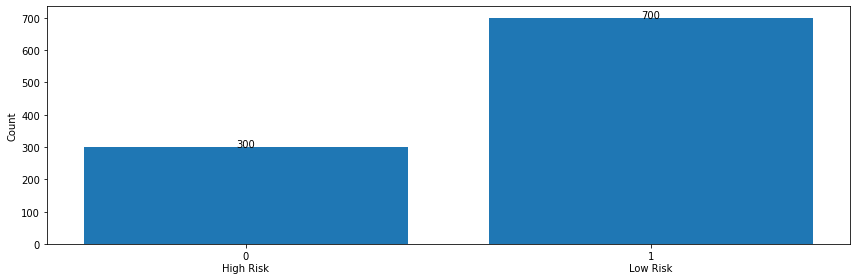

In [26]:
# Observe imbalance in dataset
    # y column indicates if bank client has "good" or "bad" credit
    # 1 = "good" (majority), 0 = "bad" (minority)
print('Value counts of response variable:')
print(y.value_counts())
plt.bar([1, 0], y.value_counts(), tick_label = ['1\nLow Risk', '0\nHigh Risk'])
[plt.text(i, y.value_counts()[i], str(y.value_counts()[i]), ha = 'center') for i in [0, 1]]
plt.ylabel('Count');
plt.tight_layout();

Confirming split percentage:
     Original data shapes:
      (1000, 48) (1000,)

     Training set shapes:
      (800, 48) (800,)

     Holdout set shapes:
      (200, 48) (200,)

Confirming stratification of class proportions (30/70):
     Original proportions:
      0.4286

     Training set proportions:
      0.4286

     Holdout set proportions:
      0.4286


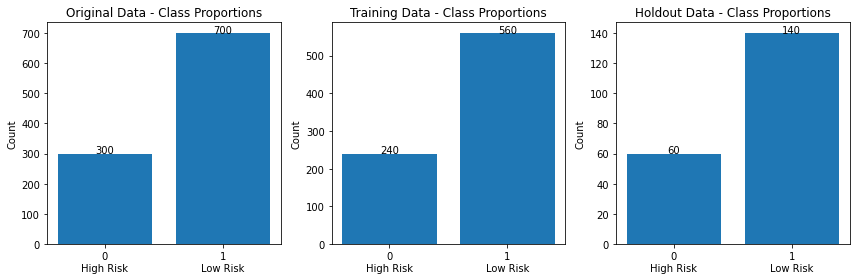

In [27]:
# Split off holdout set for use in final testing after model selection
# This shuffles data and stratifies a split with the original class proportions (70/30)
XT, XH, yT, yH = train_test_split(
    X_ind, y, test_size=0.2, random_state=1,
    shuffle=True, stratify=y)

# Checks
print('Confirming split percentage:')
print('     Original data shapes:')
print('     ', X_ind.shape, y.shape)

print('\n     Training set shapes:')
print('     ', XT.shape, yT.shape)

print('\n     Holdout set shapes:')
print('     ', XH.shape, yH.shape)

print('\nConfirming stratification of class proportions (30/70):')
print('     Original proportions:')
print('     ', np.round(y.value_counts().values[1]/y.value_counts().values[0], 4))

print('\n     Training set proportions:')
print('     ', np.round(yT.value_counts().values[1]/yT.value_counts().values[0], 4))

print('\n     Holdout set proportions:')
print('     ', np.round(yH.value_counts().values[1]/yH.value_counts().values[0], 4))

# Plots
rcParams['figure.figsize'] = (12, 4)
plt.subplot(1, 3, 1)
plt.title('Original Data - Class Proportions')
plt.bar([1, 0], y.value_counts(), tick_label = ['1\nLow Risk', '0\nHigh Risk'])
[plt.text(i, y.value_counts()[i], str(y.value_counts()[i]), ha = 'center') for i in [0, 1]]
plt.ylabel('Count');

plt.subplot(1, 3, 2)
plt.title('Training Data - Class Proportions')
plt.bar([1, 0], yT.value_counts(), tick_label = ['1\nLow Risk', '0\nHigh Risk'])
[plt.text(i, yT.value_counts()[i], str(yT.value_counts()[i]), ha = 'center') for i in [0, 1]]
plt.ylabel('Count');

plt.subplot(1, 3, 3)
plt.title('Holdout Data - Class Proportions')
plt.bar([1, 0], yH.value_counts(), tick_label = ['1\nLow Risk', '0\nHigh Risk'])
[plt.text(i, yH.value_counts()[i], str(yH.value_counts()[i]), ha = 'center') for i in [0, 1]]
plt.ylabel('Count');
plt.tight_layout();

<a class = 'anchor' id = 'section2'></a>

## Section 2: Building a Model Pipeline Function
* [Back To Top](#TOC)

In [29]:
# Function that runs applies CV and runs the sampler-model pipeline for a given set of inputs
def binary_model(X, y, K, feat_eng, scaler, sampling_method, model_name, prints = False):
    '''
    Inputs:
    *X: Pandas dataframe of features
    
    *y: Pandas dataframe or series of response variable (binary labels)
    
    *K: int, specifies the number of K splits in cross-validation. Must be greater than 1.
    
    *feat_eng: Bool, specifies if feature engineering and selection should be applied.
        If true, PolynomialFeatures will be the feature engineering 
        and PCA will be the feature selection.
        
    *scaler: Bool, specifies if the data should be scaled before being passd into the model. 
        If true, StandardScaler will be applied.
        
    *sampling_method: string, specifies which sampling method to apply. Options:
        'rus': RandomUnderSampler
        'ros': RandomOverSampler
        'smote': SMOTE oversampler
        
    *model_name: string, specifies which supervised classification model to implement. Options:
        'log_reg': LogisticRegression
        'bag': BaggingClassifier
        'gb': GradientBoostingClassifier
        'rf': RandomForest
        
    *prints: Bool, default = False, specifies whether the outputs should be printed.
        
    Outputs:
    Returns a tuple consisting of the following metrics
    *model_runtime: float, the time in seconds the model took to fit and get predictions.
    
    *model_precision: float, the precision score of the model.
    
    *model_f1_score: float, the F1 score of the model.
    
    *model_auc_score: float, the ROC-AUC score of the model.
    
    *model_accuracy: float, the accuracy score of the model.
    '''
    ## Parameter selection
    # Selects parameters from dictionaries of transformers/methods
    
#     print(X.shape, y.shape) # check
    
    # Optional transformers
    feat_eng_dict = {True:PolynomialFeatures(degree = 2), False:None}
    feat_sel_dict = {True:PCA(n_components=0.95), False:None}
    scaler_dict = {True:StandardScaler(), False:None}
    
    # Model selection
    model_dict = {'log_reg':LogisticRegression(C = 1, random_state=1),
                  'bag':BaggingClassifier(base_estimator = DecisionTreeClassifier(),
                                            n_estimators=500, max_samples=100,
                                            random_state=1, n_jobs=-1),
                  'gb':GradientBoostingClassifier(n_estimators=500, 
                                                      random_state=1),
                  'rf':RandomForestClassifier(n_estimators=500, max_depth=4,
                                             random_state=1, n_jobs=-1)}
    
    # Sampler selection
    sampler_dict = {'rus':RandomUnderSampler(random_state=1),
                    'ros':RandomOverSampler(random_state=1),
                    'smote':SMOTE(random_state=1, n_jobs=-1)}
    
    # Future edit for functionality:
        # Figure out how to disable sampler using this dict^^^
        # For creating benchmark performances using nonsampled data

    ## Model pipeline
    model_pipe = Pipeline([
        ('feat_eng', feat_eng_dict[feat_eng]),
        ('feat_sel', feat_sel_dict[feat_eng]),
        ('scaler', scaler_dict[scaler]),
        ('model', model_dict[model_name]),
    ])
    
    # Set cross-validation object and retrieve indices of splits
    cv = StratifiedKFold(n_splits = K, shuffle = True, random_state=1)
    splits = cv.split(X, y)
    
    ## Run model
    # Record time
    t = time()
    
    prec_scores = []
    f1_scores = []
    roc_auc_scores = []
    acc_scores = []
    for train_index, test_index in splits:
        # Apply sampling method to training set
        X_res, y_res = sampler_dict[sampling_method].fit_resample(X.iloc[train_index], y.iloc[train_index])
        
        # Fit model pipeline with sampled and shuffled data
        model_pipe.fit(X_res.sample(frac=1, random_state=1), y_res.sample(frac=1, random_state=1))
        
        # Obtain predictions over unsampled test set
        y_pred = model_pipe.predict(X.iloc[test_index])
        y_test = y.iloc[test_index]
        
        # Obtain metrics from predictions
        prec_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))
        acc_scores.append(accuracy_score(y_test, y_pred))
    
    ## Metrics
    model_runtime = np.round(time()- t, 3)
    model_precision = np.round(np.mean(prec_scores), 3)
    model_f1_score = np.round(np.mean(f1_scores), 3)
    model_auc_score = np.round(np.mean(roc_auc_scores), 3)
    model_accuracy = np.round(np.mean(acc_scores), 3)
    
    ## Prints and returns
    if prints:
        print(f'Total run time: {model_runtime}s')
        print(f'\nAverage precision score: {model_precision}')
        print(f'Average F1 score: {model_f1_score}')
        print(f'Average ROC AUC score: {model_auc_score}')
        print(f'Average accuracy: {model_accuracy}')
    
    return (model_runtime, model_precision, model_f1_score, model_auc_score, model_accuracy)

In [30]:
binary_model(XT, yT, 10, False, True, 'ros', 'rf')

(8.333, 0.854, 0.75, 0.698, 0.689)

<a class = 'anchor' id = 'section3'></a>

## Section 3: Generating Results
* [Back To Top](#TOC)

In [31]:
# Create dataframes to store results
model_names = {'log_reg':'Logistic Regression', 'bag':'Bagging Decision Trees',
               'gb':'Gradient Boosting', 'rf':'Random Forest'}

sampler_names = {'rus':'Random Under Sampler', 'ros':'Random Over Sampler', 
                 'smote':'SMOTE'}

df_results_time = pd.DataFrame(index = list(sampler_names.values()), columns=list(model_names.values()))
df_results_prec = pd.DataFrame(index = list(sampler_names.values()), columns=list(model_names.values()))
df_results_f1 = pd.DataFrame(index = list(sampler_names.values()), columns=list(model_names.values()))
df_results_auc = pd.DataFrame(index = list(sampler_names.values()), columns=list(model_names.values()))
df_results_acc = pd.DataFrame(index = list(sampler_names.values()), columns=list(model_names.values()))

In [32]:
# loop over all sampler and model combinations
# Stores results into dfs
tm = time()

# Loop over all models
for m in model_names.keys():
    
    # Loop over all samplers
    for s in sampler_names.keys():
        
        # Run model and save metrics
        my_runtime, my_prec, my_f1, my_auc, my_acc = binary_model(XT, yT, 10, False, True, s, m)
        
        # Store metrics into dataframes
        df_results_time.loc[sampler_names[s]][model_names[m]] = my_runtime
        df_results_prec.loc[sampler_names[s]][model_names[m]] = my_prec
        df_results_f1.loc[sampler_names[s]][model_names[m]] = my_f1
        df_results_auc.loc[sampler_names[s]][model_names[m]] = my_auc
        df_results_acc.loc[sampler_names[s]][model_names[m]] = my_acc

# Print total run time of all 12 combos
print(f'Run time of all combos: {time() - tm:.3f}s')

Run time of all combos: 66.656s


<a class = 'anchor' id = 'tables'></a>

### Tables
* [Back To Top](#TOC)

In [33]:
# Print results of each dataframe
print('Run times:')
display(df_results_time)
print('Precision scores:')
display(df_results_prec)
print('F1 scores:')
display(df_results_f1)
print('AUC scores:')
display(df_results_auc)
print('Accuracy scores:')
display(df_results_acc)

Run times:


,Logistic Regression,Bagging Decision Trees,Gradient Boosting,Random Forest
Random Under Sampler,0.361,6.302,5.728,8.217
Random Over Sampler,0.392,3.86,9.981,8.391
SMOTE,0.392,3.85,9.975,9.173


Precision scores:


,Logistic Regression,Bagging Decision Trees,Gradient Boosting,Random Forest
Random Under Sampler,0.852,0.875,0.845,0.87
Random Over Sampler,0.856,0.855,0.817,0.854
SMOTE,0.805,0.82,0.819,0.823


F1 scores:


,Logistic Regression,Bagging Decision Trees,Gradient Boosting,Random Forest
Random Under Sampler,0.754,0.724,0.748,0.725
Random Over Sampler,0.781,0.729,0.811,0.75
SMOTE,0.825,0.776,0.829,0.781


AUC scores:


,Logistic Regression,Bagging Decision Trees,Gradient Boosting,Random Forest
Random Under Sampler,0.699,0.707,0.692,0.703
Random Over Sampler,0.718,0.689,0.693,0.698
SMOTE,0.682,0.679,0.703,0.686


Accuracy scores:


,Logistic Regression,Bagging Decision Trees,Gradient Boosting,Random Forest
Random Under Sampler,0.691,0.673,0.685,0.673
Random Over Sampler,0.719,0.67,0.739,0.689
SMOTE,0.749,0.704,0.759,0.71


<a class = 'anchor' id = 'heatmaps'></a>

### Heatmaps
* [Back To Top](#TOC)

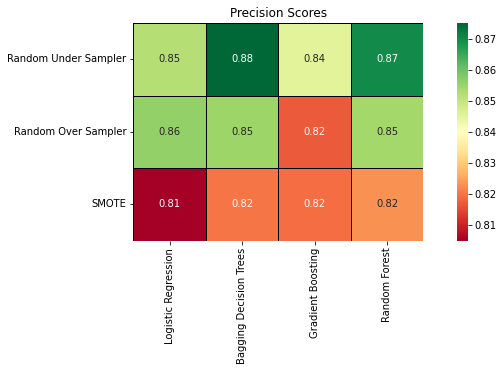

In [40]:
# Create heatmap for precision score using dataframe
sb.heatmap(df_results_prec.astype(float), cmap= 'RdYlGn', square=True,
           annot = True, linewidths=0.5, linecolor='black');
plt.title('Precision Scores');

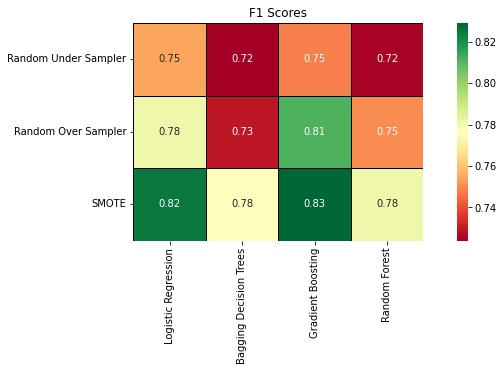

In [36]:
# Create heatmap for F1 score using dataframe
sb.heatmap(df_results_f1.astype(float), cmap= 'RdYlGn', square=True,
           annot = True, linewidths=0.5, linecolor='black');
plt.title('F1 Scores');

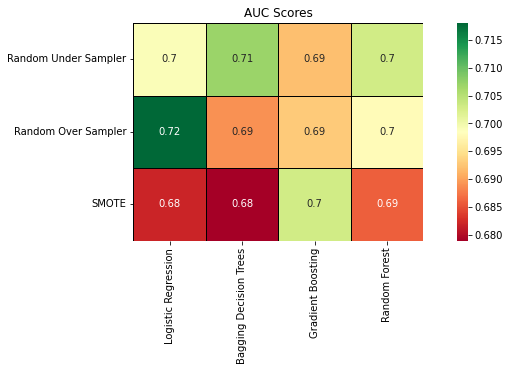

In [37]:
# Create heatmap for ROC-AUC score using dataframe
sb.heatmap(df_results_auc.astype(float), cmap= 'RdYlGn', square=True,
           annot = True, linewidths=0.5, linecolor='black');
plt.title('AUC Scores');

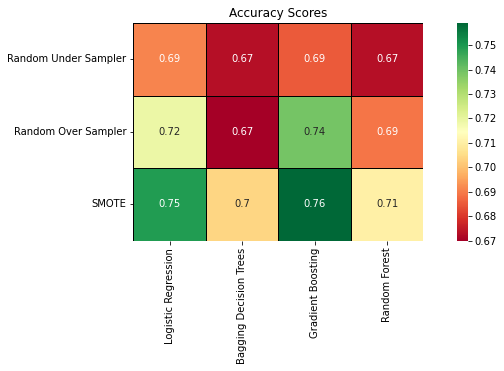

In [38]:
# Create heatmap for accuracy score using dataframe
sb.heatmap(df_results_acc.astype(float), cmap= 'RdYlGn', square=True,
           annot = True, linewidths=0.5, linecolor='black');
plt.title('Accuracy Scores');

<a class = 'anchor' id = 'section4'></a>

## Section 4: Discussion and Model Selection
* [Back To Top](#TOC)

The goal is to choose a model that reduces the false positive rate (Type I Error), which directly corresponds to increasing the precision score.

Observing the above heatmaps for the metrics, we see that the models with the highest precision scores over all samplers are the ensemble methods: bagging decision trees and random forest. Logistic regression and bagging came in third and fourth, respectively. The samplers with the highest precision scores are the random undersampler ("RUS") and the random oversampler ("ROS"), with SMOTE coming in last.

Note that there is tradeoff between precision and recall scores, such that if one is high then the other is low. The F1 score is the harmonic mean of these two metrics, so if one is very low, then the F1 score will be low. We can see that the heatmap for the F1 scores is almost opposite of the prcision score heatmap, which makes sense. The high precision scores correspond to low recall scores, resulting in low F1 scores. This correlates with the precision score heatmap.

Besides precision, we want to select a model that performs well in general, a model that rarely misclassifies. This corresponds to a high AUC score. For the AUC scores, we can see that the best performing model is the logistic model, with the bagging method coming in second, and gradient boosting and random forest nearly ties for third. For the samplers, the ROS had the best performance and the RUS was a close second.

In terms of accuracy, we see that the SMOTE method outperformed overall, with the logistic and gradient boosting models performing best. Accuracy in this scenario is the least reliable metric, as it only states how much the model got RIGHT, and ignores how much it got WRONG. In terms of generalizability, the AUC score may be a better metric than accuracy. The AUC score states how well the classifier can distingush between the classes. 


### Model Selection:

It seems that the best model-sampler combo to use would be an ensemble method with the random undersampler. These combos showed the highest precision and highest AUC scores. Since the bagging model technically had the higher precision and AUC, this one will be selected for final validation. 

<a class = 'anchor' id = 'section5'></a>

### Section 5: Final Model Validation Results
* [Back To Top](#TOC)

In [43]:
# Apply selected sampler-model combo on full dataset with cross-validation
final_model = binary_model(X_ind, y, 10, False, True, 'rus', 'bag')

# Prints of results
print('Final results using cross-validation on full dataset with K = 10')
print('Sampler: Random Undersampler')
print('Model: Bagging Ensemble')

print(f'\nRuntime: {final_model[0]}s')
print(f'Precision score: {final_model[1]}')
print(f'F1 score: {final_model[2]}')
print(f'ROC-AUC score: {final_model[3]}')
print(f'Accuracy score: {final_model[4]}')

Final results using cross-validation on full dataset with K = 10
Sampler: Random Undersampler
Model: Bagging Ensemble

Runtime: 3.767s
Precision score: 0.864
F1 score: 0.741
ROC-AUC score: 0.704
Accuracy score: 0.683


<a class = 'anchor' id = 'summary'></a>

### Summary
* [Back To Top](#TOC)

The final model, bagging ensemble with random undersampling, was ran on the full dataset using the same stratifies cross-validation function used earlier. The results are displayed above. 

With a final precision score of 0.864, the model performed relatively well in avoiding false positives. Though this was slightly less than the tested value for this sampler-model combo (0.88), this difference could be argued to be unseen statistical noise that was present in the holdout set. The other three metrics performed similarly, returning values slightly higher than the tested values for this combo.

Overall, implementing a bagging ensemble method with random undersampling was an appropriate tool for this imbalanced dataset.

<a class = 'anchor' id = 'appendix'></a>

## Appendix: Experimental Notes
* [Back To Top](#TOC)

In early versions of this project, it was intended to apply feature engineering and feature selection as a part of the model pipeline after cross-validation. It was found that applying such steps decreased significantly decreased performance across all sampler-model combinations. Metrics were returning values marginally above a random classifier, so this was abandoned. It is suspected that there were already enough features in the binarized dataset (48 in total) such that adding more may have introduced too much noise for the classifiers to perform well. Even applying principal component analysis (PCA) for the feature selection did not improve results. 

Future improvements may include producing results for unsampled data, results where the sampler is applied before cross-validation, and results where a feature selection method is applied without feature engineering. These results may serve as interesting comparisions with those presented above.